# Impedance calculation ('edge effect' of biodiversity stressors)
This block takes into account the negative effect of some human-made objects, or stressors, which can affect biodiversity and habitat connectivity. This impact can be represented as overhead landscape impedance, compared to the intrinsic resistance of landscapes to pass species through:
- simplified schema implies that each LULC type strongly matches only one value of landscape impedance (for example 1000 in urban areas and 10 in forests)
- enriched schema implies that impedance in each pixel contains the simple value summed with overhead impedance declining while moving from the stressors. For example, the landscape impedance within roads and urban areas is 1000, while in forests it is the sum of intrinsic impedance (10) and overhead. Overhead is close to 1000 in forests adjacent to urban areas, but it is declining while moving away from the stressor. 

The character and pace of decline (or decay rate) of edge effect is defined in the configuration files. Meanwhile, it must be revisited by user and adjusted, because the character of negative impact decline can vary significantly, depending on study area, species, stressors and land-use/land-cover. The default values of edge effect are given only for testing this tool.

It depends on user whether they use this tool to create the detailed representation of landscape impedance or apply the simplified schema.

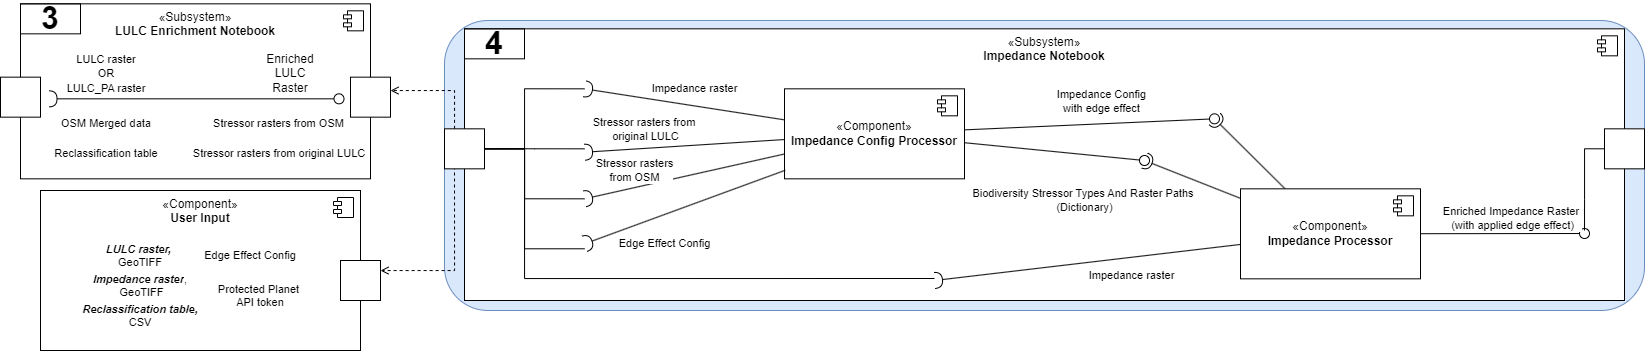
**INPUT (mandatory)**
- Impedance raster dataset (GeoTIFF)
- LULC raster dataset and its derivatives from the previous Notebook - stressors (GeoTIFF)
- OSM raster datasets with rasterised spatial features (GeoTIFF)
- configuration of edge effect from user: which LULC categories cause edge effect (0...\*,) which OSM spatial features can cause edge effect (0...\*), defined in [CSV](data/input/impedance/lulc_descr_esa.csv)
- parameters of edge effect from stressors [(YAML configuration file)](config_impedance.yaml)

**OUTPUT**
- enriched impedance raster dataset with applied edge effect (GeoTIFF)

**NOTES**
- gdal_proximity computes proximity between centroids of corresponding raster pixels (for example, proximity from the edge of roads, but from the centroid of first pixel)
r.grow.distance (GRASS) might be used instead of gdal to generate the distances to the nearest points of target pixels, but it is unclear if gdal represents the actual distances better.
- Outputs from Open Street Map can have a larger spatial extent than initial raster datasets (land-use/land-cover). It is not an issue as long as LULC bounding box is fully contained within the bounding boxes of OSM outputs.
Moreover, bounding box can vary across Open Street Map outputs, depening on the geometry of spatial features covering LULC dataset.
- No data values in the entire output raster dataset while calculating raster proximity (only for the last stressors from LULC in the loop + all stressors from OSM). 
14/10/2024: solved for the last stressor from LULC (more FlushCache() and ...= none statements). To avoid similar issues, initialise VRT dataset after running gdal.RasterProximity and taking No Data value directly from input raster dataset (stressors).

#### Dependencies and configuration

In [1]:
import geopandas as gpd
import yaml
import warnings
import os
import sys
import numpy as np
from collections import OrderedDict # to order entries in YAML
import re
import copy
from typing import Optional
'''from anytree import Node, RenderTree''' # not required anymore

# local imports
from utils import find_stressor_params
import timing
timing.start()

Specify the configuration (brought from previous Notebooks and updated):

In [2]:
from abc import ABC, abstractmethod
import os 

In [ ]:
class ImpedanceConfigProcessor(ABC):
    """Abstract class for processing impedance configuration files."""
    
    def __init__(self, config:dict, config_impedance:dict, params_placeholder:dict, impedance_stressors:dict, year:int, 
        parent_dir:str, output_dir:str) -> None:
        """Initializes the ImpedanceConfigProcessor class.

        Args:
            config (dict): The configuration yaml file.
            config_impedance (dict): The impedance configuration yaml file.
            params_placeholder (dict): The dictionary template for the configuration YAML file (for each stressor).
            impedance_stressors (dict): The dictionary for stressors, mapping stressor raster path to YAML alias.
            year (int): The year for which the edge effect is calculated.
            parent_dir (str): The parent directory
            output_dir (str): The output directory
        """
        super().__init__()
        self.config = config
        self.config_impedance = config_impedance
        self.params_placeholder = params_placeholder
        self.impedance_stressors = impedance_stressors
        self.year = year
        self.parent_dir = parent_dir
        self.output_dir = output_dir
        
    @abstractmethod
    def update_impedance_config(self, *args, **kwargs) -> tuple[dict,dict]:
        """Updates the impedance configuration file with stressors and default decay parameters.
        
        Returns:
            impedance_dictionaries (tuple): Tuple containing two dictionaries:
                - Impedance_stressors (dict) The dictionary of stressors, mapping stressor raster path to YAML alias.
                - Impedance_configuration (dict): The updated configuration file mapping stressors to default decay parameters.
        """
        ...


### Populating impedance configuration with stressors from LULC
Firstly, we need to find out which stressors can be directly fetched from the input LULC dataset as a separate categories. These stressors are defined in a 'edge_effect' column of [CSV](data/input/impedance/lulc_descr_esa.csv). If LULC code is characterised by 1, then it is considered a stressor, otherwise LULC code do not affect habitats. In the sample dataset, only built areas are stressors, but user can always consider different stressors, changing values in this column.

In [ ]:
import os
import yaml
import warnings
import geopandas as gpd
import numpy as np
import copy
from typing import Optional, Iterator
from utils import get_lulc_template
# from interfaces.ImpedanceConfigProcessor import ImpedanceConfigProcessor

In [ ]:
class Lulc_impedance_processor(ImpedanceConfigProcessor): 
    """
    The LULC_impedance_processor class processes the LULC raster dataset to extract stressors causing edge effect on habitats.
    It creates a masked raster file for each LULC code and updates the impedance configuration file with the LULC stressors.
    """

    def __init__(self, config_impedance:dict, config:dict, params_placeholder:dict, impedance_stressors:dict, year:int, parent_dir:str,output_dir:str) -> None:
        """
        Initialize the Impedance class with the configuration file paths and other parameters.

        Args:
            config (dict): The configuration file.
            config_impedance (dict): The impedance configuration file.
            params_placeholder (dict): The dictionary template for the configuration YAML file (for each stressor).
            impedance_stressors (dict): The dictionary for stressors, mapping stressor raster path to YAML alias.
            year (int): The year for which the edge effect is calculated.
            parent_dir (str): The parent directory
            output_dir (str): The output directory
        """
        super().__init__(config, config_impedance, params_placeholder, impedance_stressors, year,parent_dir,output_dir)
        # additional directories
        self.lulc_dir = self.config.get('lulc_dir')
        self.impedance_dir = self.config.get('impedance_dir')
  
    def update_impedance_config(self):
        """
        Sequentially calls the methods to update the impedance configuration file with stressors and default decay parameters.
        - Updates the impedance configuration file with stressors and default decay parameters
        - Creates a masked raster file for each LULC code.
        - Updates the impedance stressors dictionary with the LULC stressors and their raster paths.

        Returns:
            impedance_stressors (dict): The dictionary of stressors with the LULC code as the key and the path to the raster file as the value.
            config_impedance (dict): The updated configuration file with the LULC stressors added.
        """
        # define the path to the LULC raster dataset
        self.lulc_path = os.path.normpath(os.path.join(self.lulc_dir,get_lulc_template(self.config,self.year)))
        self.lulc_properties = self.get_lulc_raster_properties(self.lulc_path)
        self.impedance_stressors = self.extract_lulc_stressors(self.year)
        return self.impedance_stressors, self.config_impedance

        
    def get_lulc_raster_properties(self,lulc_path:str):
        """
        Create a dictionary of properties for the LULC raster dataset to be used when masking the raster with LULC codes.

        Args:
            lulc_path (str): The path to the LULC raster dataset.
        Returns:
            lulc_properties (dict): The dictionary of properties for the LULC raster dataset.
        """
        # create a dictionary to store the properties of the LULC raster dataset
        lulc_properties = {}

        # Open the LULC as an array (and extract its no data value and data type for logging):
        lulc = gdal.Open(lulc_path)
        lulc_properties['band'] = lulc.GetRasterBand(1)
        lulc_properties['band_array'] = lulc_properties['band'].ReadAsArray()
        lulc_properties['nodata_value'] = lulc_properties['band'].GetNoDataValue()
        lulc_properties['band_data_type'] = lulc_properties['band'].DataType
        lulc_properties['geotransform'] = lulc.GetGeoTransform()
        lulc_properties['projection'] = lulc.GetProjection()
        lulc_properties["x_size"] = lulc.RasterXSize
        lulc_properties["y_size"] = lulc.RasterYSize

        # close the raster dataset
        lulc = None

        print("NoData value:", lulc_properties['nodata_value']) # debug
        print("Data type of the band:", gdal.GetDataTypeName(lulc_properties['band_data_type']))# debug

        return lulc_properties

    def load_impedance_data(self) -> gpd.GeoDataFrame:
        """
        Load the impedance data from the configuration file and the CSV file.

        Args:
            None

        Returns:
            gpd.GeoDataFrame: The impedance data as a GeoDataFrame
        """
        impedance = self.config.get('impedance')
        if impedance is not None:
            print(f"Using auxiliary tabular data from {impedance}.")
        else:
            warnings.warn("No valid auxiliary tabular data found. Impact from stressors will be estimated from vector features only.") # warning, not error because stressors might come from CSV file pointing out LULC categories and from OSM vector dataset (at least one source or both)
            return None
        impedance_csv = os.path.join(self.impedance_dir,impedance) # define path
        
        return gpd.read_file(impedance_csv) # read CSV file through geopandas as a dataframe


    
    def extract_lulc_stressors(self, year:int, edge_effect_val:int = 1) -> dict:
        """
        Extracts the LULC types causing edge effect on habitats from the input CSV dataset.
        Each stressor is appended into the impedance configuration file as a separate entry and a masked raster file is created for each LULC code.

        Args:
            year (int): The year for which the edge effect is calculated.
            edge_effect_val (int): The value in the 'edge_effect' column of the CSV file which indicates that the LULC code causes edge effect on habitats. Default is 1.
        Returns:
            impedance_stressors (dict): The dictionary of stressors with the LULC code as the key and the path to the raster file as the value.
        """
        # сreate an empty list to store LULC codes which cause negative impact on habitats and edge effect
        edge_effect_list = []
        # 1. check if initial_lulc is enabled
        self.initial_lulc = self.config_impedance.get('initial_lulc', {"enabled":False})
        if self.initial_lulc.get('enabled') is True:
            print("Some categories from the input LULC dataset are considered as stressors...")

            # 2. check if the value in 'edge_effect' column is 1 - user specified that these LULC are affecting habitats
            impedance_df = self.load_impedance_data()
            if impedance_df is not None:
                # convert datatype of 'edge_effect' column into integer one if needed
                impedance_df['edge_effect'] = impedance_df['edge_effect'].astype(int)
                edge_effect_list = impedance_df[impedance_df['edge_effect'] == edge_effect_val]['lulc'].tolist()
                print (f"LULC type codes causing edge effect on habitats are: {edge_effect_list}")
                print("-"*40)
                
                # 3. iterate over each LULC code in edge_effect_list
                for lulc_code, lulc_code_str in self.populate_initial_lulc(edge_effect_list,year,self.params_placeholder):
                    try: 
                        # 4. create a mask for the current LULC code
                        self.impedance_stressors = self.mask_with_lulc_code(lulc_code, lulc_code_str)
                    except Exception as e:
                        print(f"Skipping LULC code {lulc_code}: {e}")
                        continue

                # 5. after processing all LULC codes, save the updated YAML configuration
                self.config_impedance['initial_lulc'] = self.initial_lulc
                with open('config_impedance.yaml', 'w') as yaml_file:
                    yaml.dump(self.config_impedance, yaml_file, default_flow_style=False)
                    print("Updated YAML configuration saved to config_impedance.yaml")

        else:
            print("No LULC categories from the input LULC raster dataset are considered stressors. Therefore, stressors will be extracted from vector data only.")
            print("-" * 40)

        return self.impedance_stressors

    def populate_initial_lulc(self, edge_effect_list: list, year:int, params_placeholder:dict) -> Iterator[tuple[str,str,dict]]:
        """
        Populates the initial_lulc dictionary with the LULC codes causing edge effect on habitats using placeholder values.
        If

        Args:
            edge_effect_list (list): The list of LULC codes causing edge effect on habitats.
            year (int): The year for which the edge effect is calculated.
            params_placeholder (dict): The dictionary template for the configuration YAML file (for each stressor).
        Returns:
            lulc_code (str): The LULC code causing edge effect on habitats.
            lulc_code_str (str): The string representation of the LULC code for YAML. For example, 'stressor_lulc_20_2015'.
        """
        for lulc_code in edge_effect_list:
            # convert lulc_code to string to match YAML keys
            lulc_code_str = f"stressor_lulc_{lulc_code}_{year}"

            # check if the current lulc_code has corresponding settings in the YAML file
            if lulc_code_str not in self.config_impedance['initial_lulc']:
                # if not found, create new keys for the LULC code with placeholders
                print(f"No specific settings found for LULC code {lulc_code}. Creating placeholder values.")
                
                # cast the placeholder dictionary into initial_lulc for a specific LULC code
                self.initial_lulc[lulc_code_str] = copy.deepcopy(params_placeholder) # deep copy, otherwise YAML creates placeholders like &id001
                
                # TODO add prompt to user to fill in the parameters
                print(f"""
                    New entry for LULC code {lulc_code} created in the YAML file with default values. 
                    {self.initial_lulc[lulc_code_str]}
                    Please fill in the values you think are more relevant.
                """)
                # print(f"Settings for LULC code {lulc_code}:\n{self.config_impedance['initial_lulc'][lulc_code_str]}")

            # else the lulc code setting alreay exists, so retain it
            else:
                print(f"Settings for LULC code {lulc_code} are filled in the YAML file.")
                self.initial_lulc[lulc_code_str] = self.config_impedance['initial_lulc'][lulc_code_str]
            # adding the raster structure to self.config_impedance
            self.config_impedance['initial_lulc'] = self.initial_lulc
            '''print(yaml.dump(self.config_impedance, default_flow_style=False))''' # debug

            yield lulc_code, lulc_code_str
            
    def mask_with_lulc_code(self, lulc_code:str, lulc_code_str:str) -> dict:
        """
        Creates a GeoTIFF raster file by masking the LULC raster dataset with a specific LULC code.

        Args:
            lulc_code (str): The LULC code to be used for masking.
            lulc_code_str (str): The string representation of the LULC code for YAML. For example, 'stressor_lulc_20_2015'.
        Returns:
            impedance_stressors (dict): The dictionary of stressors with the LULC code as the key and the path to the raster file as the value.
        """
        # 4. create a mask for the current LULC code
        mask = (self.lulc_properties['band_array'] == int(lulc_code))
        if np.any(mask):
            print(f"True values are present in the mask for LULC code: {lulc_code}.")
        else:
            print(f"No True values are present in the mask for LULC code: {lulc_code}.")

        # apply mask to LULC
        masked_data = np.where(mask, self.lulc_properties['band_array'], self.lulc_properties['nodata_value'])
        if np.any(masked_data != 0):
            print(f"Valid data is present in masked data for LULC code: {lulc_code}.")
        else:
            print(f"Masked data contains only zeros or nodata values for LULC code: {lulc_code}.")
            return self.impedance_stressors # Added to avoid processing empty rasters (for example, if stressors in protected areas are not used in this Notebook)

        #  create unique output raster path for each LULC code
        output_raster_path = os.path.join(self.output_dir, f'{lulc_code_str}.tif')
        # APPEND outputs with stressors to the list
        self.impedance_stressors[lulc_code_str] = output_raster_path  # mapping stressor raster path to LULC code

        # create output raster file
        driver = gdal.GetDriverByName('GTiff')
        out_dataset = driver.Create(output_raster_path, self.lulc_properties["x_size"], self.lulc_properties["y_size"], 1, self.lulc_properties['band_data_type'])
        out_dataset.SetGeoTransform(self.lulc_properties['geotransform'])
        out_dataset.SetProjection(self.lulc_properties['projection'])

        # write the masked data to the new raster file
        out_band = out_dataset.GetRasterBand(1)
        out_band.WriteArray(masked_data)
        nodata_value_int = int(self.lulc_properties['nodata_value'])
        out_band.SetNoDataValue(nodata_value_int)

        # flush data to disk
        out_band.FlushCache() # note: if delete it the last output will be invalid
        out_dataset.FlushCache()

        out_band = None
        out_dataset = None

        print(f"Masked LULC data for code {lulc_code} affecting habitats with edge effect saved to: {output_raster_path}")
        print("-" * 40)

        print(f"All stressors from initial LULC dataset saved successfully: {self.impedance_stressors.keys()}")
        print("-" * 40)
        
        return self.impedance_stressors

In [6]:
from utils import load_yaml
from osgeo import gdal
import os
import copy
import yaml
# from interfaces.ImpedanceConfigProcessor import ImpedanceConfigProcessor


### Populating impedance configuration with stressors from OSM
Another portion of stressors comes from another source - rasterised vector features (being produced in the [3rd Notebook](3_preprocessing.ipynb)), recommended to be fetched from Open Street Map. For the sample dataset, two types of stressors are being used - railways and roads. Moreover, it is implemented to define a different parameters for subtypes of vector features, in this case, for roads - it is justified by the fact that roads vary by width and traffic frequency.

In [ ]:
class Osm_impedance_processor(ImpedanceConfigProcessor):
    """
    The Osm_impedance_processor class processes the OSM vector dataset to extract stressors causing edge effect on habitats.
    It updates the impedance configuration file with the OSM stressors (raster files for each OSM feature and subtype are created in 3rd notebook)
    """
    def __init__(self, config_impedance:dict, config:dict, params_placeholder:dict, impedance_stressors:dict, year:int,
            parent_dir:str,output_dir:str,osm_stressor_path:str="stressors.yaml") -> None:
        """
        Initialize the Impedance class with the configuration file paths and other parameters.

        Args:

            config (dict): The configuration file.
            config_impedance (dict): The impedance configuration file.
            params_placeholder (dict): The dictionary template for the configuration YAML file (for each stressor).
            impedance_stressors (dict): The dictionary for stressors, mapping stressor raster path to YAML alias.
            year (int): The year for which the edge effect is calculated.
            parent_dir (str): The parent directory
            output_dir (str): The output directory
            osm_stressor_path (str): The path to the OSM stressors YAML file. Default is 'stressors.yaml'.
        """
        super().__init__(config, config_impedance, params_placeholder, impedance_stressors, year, parent_dir,output_dir)

        # additional directories
        self.vector_dir = self.config.get('vector_dir')

        # load road/railway types from the configuration file from the 3rd notebook
        self.osm_stressor_path = osm_stressor_path

        # # get the maximum value from the impedance raster dataset
        # if impedance_tif is not None:
        #     impedance_ds = gdal.Open(impedance_tif) # open raster impedance dataset
        #     impedance_max = get_max_from_tif(impedance_ds) # call function from above
        #     print (f"Impedance raster GeoTIFF dataset used is {impedance_tif}") # debug
        #     print (f"Maximum value of impedance dataset: {impedance_max}") # debug
        #     # close the dataset
        #     impedance_ds = None
        # else:
        #     raise FileNotFoundError(f"Impedance raster GeoTIFF dataset '{impedance_tif}' is not found! Please check the configuration file.") # stop execution

    def update_impedance_config(self):
        """
        Sequentially calls the methods to update the impedance configuration file with stressors and default decay parameters.
        - Updates the impedance configuration file with OSM stressors and default decay parameters.
        - Updates the impedance stressors dictionary with the OSM stressors and their raster paths.

        Returns:
            tuple: Tuple containing two dictionaries:
                - Impedance_stressors (dict) The dictionary of stressors, mapping stressor raster path to YAML alias.
                - Impedance_configuration (dict): The updated configuration file mapping stressors to default decay parameters.
        """
        
        osm_stressors = load_yaml(self.osm_stressor_path)
        self.config_impedance = self.prepare_config_impendance_file(osm_stressors)
        # add the OSM stressors to the impedance configuration file
        for osm_stressor_feature,osm_feature_subtypes in osm_stressors.items():
            if osm_feature_subtypes is not None:
                for osm_feature_subtype in osm_feature_subtypes:
                    raster_path = os.path.normpath(os.path.join(self.output_dir,f'{osm_stressor_feature}_{osm_feature_subtype}_{self.year}.tif'))
                    self.impedance_stressors[osm_feature_subtype] = raster_path
            # if there are no subtypes, add the feature itself
            else:
                raster_path = os.path.normpath(os.path.join(self.output_dir,f'{osm_stressor_feature}_{self.year}.tif'))
                self.impedance_stressors[osm_stressor_feature] = raster_path

        return self.impedance_stressors, self.config_impedance
    
    def prepare_config_impendance_file(self, osm_stressors:dict):
        """
        Inserts the OSM stressors and subtypes (for example the 'road' OSM feature has a subtype 'motorway') into the impedance configuration file.
        
        - Example osm_stressor_dict:
        { 
            roads: ['trunk', 'motorway', 'primary', 'secondary', 'tertiary'] # road types to be extracted from OSM
            railways: ['rail', 'light_rail', 'subway'] # railway types to be extracted from OSM
        }

        Args:
            osm_stressor_dict (dict): dictionary of OSM stressors and their subtypes
        Returns:
            dict: updated configuration file with OSM stressors and subtypes
        """
        vector = self.config_impedance.get('vector', {}) # access the vector section in YAML
  
        for osm_stressor_feature, osm_stressor_feature_subtypes in osm_stressors.items(): 
            print(f"Processing {osm_stressor_feature}...")
            # 1. create or update the key for each osm_stressor_feature in 'vector'
            if osm_stressor_feature not in vector:
                vector[osm_stressor_feature] = {}  # initialize the osm_stressor_feature as an empty dictionary
                
            # define the 'types' key for each osm_stressor as an empty dictionary (will be updated later)
            vector[osm_stressor_feature]['types'] = None  # initialize 'types' with empty value

            # check if the subtypes variable is not empty (contains subtypes)
            if osm_stressor_feature_subtypes is not None:
                # update the types in the vector for the current osm_stressor
                vector[osm_stressor_feature]['types'] = True # Update types with True
                # loop through each subtype in the dynamic variable
                for stressor_subtype in osm_stressor_feature_subtypes:
                    # write params_placeholder to vector for each type
                    vector[osm_stressor_feature][stressor_subtype] = copy.deepcopy(self.params_placeholder)
            else:
                # update the types in the vector for the current osm_stressor
                vector[osm_stressor_feature]['types'] = None # update types with empty value
                vector[osm_stressor_feature] = copy.deepcopy(self.params_placeholder)
                
        # update the 'vector' section back into the main config_impedance
        self.config_impedance['vector'] = vector

        return self.config_impedance


In [8]:
import os
import yaml
import warnings
import geopandas as gpd
import numpy as np
import copy
from typing import Optional, Iterator

# Impedance Configuration Processor

This is a wrapper class to populate the [config_impedance.yaml](config_impedance.yaml) file with the lulc and osm stressors. This configuration is a temporary file that will be used for impedance recalculation. 

In [ ]:
class Impedance_config_processor(): 
    """
    This class is responsible for processing the configuration file for the impedance dataset for the lulc and osm stressors
    The lulc stressors are defined in the reclassification CSV file and the osm stressors are defined in the stressors.yaml file (from the 3rd notebook)
    """

    def __init__(self, year:int, params_placeholder:dict, config:dict, config_impedance:dict):
        """
        Initialize the Impedance class with the configuration file paths and other parameters.

        Args:
            year (int): The year for which the edge effect is calculated.
            params_placeholder (dict): The dictionary template for the configuration YAML file (for each stressor).
            config_path (str): The path to the main configuration file. Default is 'config.yaml'.
            config_impedance_path (str): The path to the impedance configuration file. Default is 'config_impedance.yaml'.
        
        Returns:
            None
        """
        # self.params_placeholder = params_placeholder 
        # self.impedance_stressors_dict = impedance_stressors_dict
        self.config = config
        self.params_placeholder = params_placeholder
        self.year = year
        self.config_impedance = config_impedance
        
        self.impedance_stressors = {} # initialize the dictionary for stressors, which contains mapping stressor raster path to YAML alias


    def setup_config_impedance(self) -> None:
        """
        Handle the initial setup of the configuration file for impedance
        """
        # ensure 'initial_lulc' exists and handle 'enabled' field logic (various cases)
        if self.config_impedance.get('initial_lulc', None) is None:
            # create 'initial_lulc' with 'enabled' set to 'false' if it doesn't exist or is None
            self.config_impedance['initial_lulc'] = {'enabled': 'false'}
        else:
            # if 'enabled' doesn't exist in 'initial_lulc', add it and set to 'false'
            if self.config_impedance['initial_lulc'].get('enabled', None) is None:
                self.config_impedance['initial_lulc']['enabled'] = 'false'

        #NOTE: FOR DEBUGGING
        print("Initial structure of the configuration file for impedance dataset:")
        print(yaml.dump(self.config_impedance, default_flow_style=False))
        print("-" * 40)

        return self.config_impedance
    
    def process_stressors(self, parent_dir:str, output_dir:str) -> dict:
        """
        Process the stressors for lulc and osm data and update the configuration file with the stressors and default decay parameters.

        Args:
            parent_dir (str): The parent directory
            output_dir (str): The output directory
        Returns:
            dict: The dictionary of stressors with the stressor type as the key and the path to the raster file as the value.
        """
        lip = Lulc_impedance_processor(self.config_impedance,self.config, self.params_placeholder, self.impedance_stressors, self.year, parent_dir, output_dir)
        self.impedance_stressors, self.config_impedance = lip.update_impedance_config()
        oip = Osm_impedance_processor(self.config_impedance, self.config, self.params_placeholder, self.impedance_stressors, self.year, parent_dir, output_dir)
        self.impedance_stressors, self.config_impedance = oip.update_impedance_config()

        return self.impedance_stressors, self.config_impedance


In [10]:
# from impedance_config_processor import Impedance_config_processor
import warnings
from utils import load_yaml, save_yaml, get_max_from_tif
from osgeo import gdal
import numpy as np
import os

## Impedance Recalcuation

1. open stressor raster dataset, extract no data value, their count and specifications of transformations
2. calculate raster proximity (distance in each pixel of raster to stressor)
3. calculate edge effect from stressors

In [ ]:
class Impedance_processor():
    """
    The Impedance_processor class processes the impedance raster dataset to calculate the edge effect on habitats.
    It computes the proximity raster for each stressor and calculates the edge effect based on the proximity data and the configuration parameters.
    """

    def __init__(self, max_result:float,cumul_result:float, parent_dir:str, output_dir:str, config_impedance:dict, yaml_stressor:str, stressor_raster, driver, mem_driver, impedance_ds, impedance_max) -> None:
        """
        Initialize the Impedance class with the configuration file paths and other parameters.

        Args:
            max_result (float): The maximum result for the impedance calculation.
            cumul_result (float):  **NOT IMPLEMENTED YET** The cumulative result for the impedance calculation.
            parent_dir (str): The parent directory
            output_dir (str): The output directory
            config_impedance (dict): The impedance configuration file.
            yaml_stressor (str): The YAML alias for the stressor.
            stressor_raster (str): The path to the stressor raster dataset.
            driver: The GDAL driver for the raster dataset.
            mem_driver: The GDAL driver for the in-memory dataset.
            impedance_ds: The impedance raster dataset.
            impedance_max: The maximum value for the impedance dataset.
        """
        self.max_result = max_result
        self.cumul_result = cumul_result
        self.parent_dir = parent_dir
        self.output_dir = output_dir
        self.config_impedance = config_impedance
        self.yaml_stressor = yaml_stressor
        self.stressor_raster = stressor_raster
        self.driver = driver
        self.mem_driver = mem_driver
        self.impedance_ds = impedance_ds
        self.impedance_max = impedance_max
        # open the input raster dataset
        self.ds = gdal.Open(stressor_raster)

    def handle_no_data(self) -> tuple[int, tuple[float,float], str]:
        """
        Handle the no data values in the input raster dataset.

        Returns:
            tuple: Tuple containing the no data value, the geotransform, and the projection of the input raster dataset.
        """

        self.input_band = self.ds.GetRasterBand(1)
        self.nodata_value = self.input_band.GetNoDataValue()
        print(f"Original no data value for input dataset is {self.nodata_value}") # debug
        if self.nodata_value is None:
            self.nodata_value = -9999  
            self.input_band.SetNoDataValue(self.nodata_value)
        print(f"No data value for input dataset is {self.nodata_value}") # debug

        data = self.input_band.ReadAsArray()
        # debug
        min_value = np.min(data)
        max_value = np.max(data)
        print(f"Range of values in the data: {min_value} to {max_value}")

        no_data_count = np.sum(data == self.nodata_value) # supposed to be non-zero
        print (f"No data count: {no_data_count}")

        # get the geo-transform (affine transformation parameters)
        self.geotransform = self.ds.GetGeoTransform()
        self.projection = self.ds.GetProjection()
        return self.nodata_value, self.geotransform, self.projection

    def compute_proximity(self):
        """
        Compute the proximity raster for the stressor raster dataset.

        Returns:
            np.ndarray: The proximity data as a NumPy array.
        """
        output_ds = self.mem_driver.Create('', self.impedance_ds.RasterXSize, self.impedance_ds.RasterYSize, 1, gdal.GDT_Int32) # Int64 might not support .SetNoDataValue()
        # NOTE: it is not possible to specify no data value directly in gdal_create

        # set geotransform parameters from input file
        if self.geotransform:
            output_ds.SetGeoTransform(self.geotransform)
        if self.projection:
            output_ds.SetProjection(self.projection)

        output_band = output_ds.GetRasterBand(1)
        
        try:
            gdal.ComputeProximity(self.input_band, output_band, ['DISTUNITS=GEO', f'NODATA={self.nodata_value}']) 
        except RuntimeError as e:
            print(f"Error computing proximity for {self.stressor_raster}: {str(e)}")

        # 3.1 read proximity data as a NumPy array for validation/debugging
        proximity_data = output_band.ReadAsArray()
        output_nodata_value = output_band.GetNoDataValue()
        print(f"NoData value of output raster is {output_nodata_value}")
        # print(proximity_data) # debug: 0 for all pixels of last raster

        output_nodata_count = np.sum(proximity_data == output_nodata_value)
        print(f"Output no data count is {output_nodata_count}") # supposed to be 0
        print(f"No data value for output dataset is {output_nodata_value}") # debug

        # warn if no data values are detected
        if output_nodata_count > 0:
            warnings.warn(f"No data values have been detected in the proximity raster for {self.stressor_raster}. Check the validity of the input vector dataset.")

        # create a VRT file as a reference to the proximity raster in memory
        vrt_output_path = os.path.join(self.output_dir, f'{os.path.basename(self.stressor_raster).replace(".tif", "")}_dist.vrt')
        vrt_options = gdal.BuildVRTOptions(resampleAlg='nearest')

        # build VRT from the in-memory proximity dataset
        vrt_ds = gdal.BuildVRT(vrt_output_path, [output_ds], options=vrt_options)

        # debug: export proximity raster to GeoTIFF
        tiff_output = f'{os.path.basename(self.stressor_raster).replace(".tif", "")}_dist.tif'
        dist_tiff_output = os.path.normpath(os.path.join(self.parent_dir, self.output_dir ,tiff_output))
        print(f"Distance path: {dist_tiff_output}") # debug
        gdal.Translate(dist_tiff_output, vrt_ds, format="GTiff", outputType=gdal.GDT_Int32, creationOptions=["COMPRESS=LZW"])
        # debug
        if os.path.exists(dist_tiff_output):
            print(f"File successfully created: {dist_tiff_output}")
        else:
            print(f"Error: File not created at: {dist_tiff_output}")

        # flush the cache
        output_band.FlushCache()
        vrt_ds.FlushCache()
        output_ds.FlushCache()

        return proximity_data
    
    def find_param(self, stressor_dict, search_key):
        """
        Find the parameter in the stressor dictionary by searching the key recursively

        Args: 
            stressor_dict (dict): The dictionary of stressor parameters.
            search_key (str): The key to search in the dictionary.

        Returns:
            value: The value of the key in the dictionary.
        """
        for key, value in stressor_dict.items():
            if key == search_key:
                return value
            elif isinstance(value, dict):
                return self.find_param(value, search_key)


    def calculate_edge_effect(self, proximity_data: np.ndarray):
        """
        Calculate the edge effect based on the proximity data and the impedance configuration parameters (decay type, lambda decay, k-value).

        Args:
            proximity_data (np.ndarray): The proximity data as a NumPy array.

        Returns:
            np.ndarray: The maximum result for the impedance calculation.
        """
        # NOTE: decay might vary across classes of stressors. For example, primary and tertiary roads will have the different negative impact on natural habitats. 
        # In first case it will occur more likely at some distance than in the second case.
        # therefore, we attempt to define different decay parameter by types of vector dataset
         # set decay output path
        edgeEff_output_path = os.path.join(self.output_dir, f'{os.path.basename(self.stressor_raster).replace(".tif", "")}_edge.tif')
        print(f"Path to output raster dataset with calculated edge effect: {edgeEff_output_path}") # debug

        # get corresponding parameter for each stressor
        stressor_params = find_stressor_params(self.config_impedance, self.yaml_stressor)
        print(f"Stressor parameters: {stressor_params}") # debug
        decline_type = self.find_param(stressor_params, 'decline_type')
        lambda_decay = self.find_param(stressor_params, 'lambda_decay')
        k_value = self.find_param(stressor_params, 'k_value')

        # debug
        print(f"""Fetched parameters for the stressor: 
            {decline_type} (type of decline), 
            {lambda_decay} (lambda decay parameter), 
            {k_value} (k-value of proportional decline)"""
        )

        # calculate impedance now
        if decline_type == 'exp_decline':
            result = self.impedance_max * np.exp(-proximity_data / lambda_decay) # impedance_max value has already been extracted through a separate function
            print(f"Decline type is {decline_type}. Expression to calculate edge effect: {self.impedance_max} * exp(- proximity_data / {lambda_decay})") # debug
        elif decline_type == 'prop_decline':  # proportional decay 
            result = np.maximum(self.impedance_max - k_value * proximity_data, 0)
            print(f"Decline type is {decline_type}. Expression to calculate edge effect: max({self.impedance_max} - {k_value} * proximity_data, 0)") # debugt

        # set values < 0 to no data value
        result[result <= 0] = self.nodata_value
        result = np.ma.masked_equal(result, self.nodata_value)

        # combine the results: keep the maximum value for each pixel throutgh iterations (keep the larger impedance)
        if self.max_result is None:
            self.max_result = result.copy()  # initialize with the first raster's result
        else:
            self.max_result = np.maximum(self.max_result, result)  # take max of previous and current
        
        # FOR CUMULATIVE FUNCTION OF DIFFERENT STRESSORS 
        '''
        # combine the results from each raster by summing
        if self.cumul_result is None:
            self.cumul_result = result.copy()  # initialize with a copy of the first raster
        else:
            self.cumul_result += result  # increment cumulative result
        '''
        # define edge effect result for export
        out_result = self.driver.Create(edgeEff_output_path, self.impedance_ds.RasterXSize, self.impedance_ds.RasterYSize, 1, gdal.GDT_Int32, ['COMPRESS=LZW']) # compress
        # set geotransform and projection before exporting
        out_result.SetGeoTransform(self.geotransform)
        out_result.SetProjection(self.projection)
        
        # write the masked result to the output raster's first band
        out_band = out_result.GetRasterBand(1)

        # set the nodata value in the band
        if self.nodata_value is not None:
            out_band.SetNoDataValue(self.nodata_value)  # define nodata 

        # write array to the band of output dataset (export)
        out_band.WriteArray(result)

        # clean up intermediate objects by flushing the cache
        # flush the cache
        out_band.FlushCache()
        out_result.FlushCache()
        self.ds.FlushCache()   

        print(f"Finished processing: {self.stressor_raster}")
        print("-" * 40)
        
        return self.max_result # return the maximum result to be used in the next iteration

    def update_impedance_with_decay(self) -> str:
        """
        Once the edge effect for all stressors is calculated, this function will be called to generate a maximum result raster.
        The maximum result is the maximum impedance value for each pixel across all stressors.

        Returns:
            str: The path to the maximum result raster GeoTIFF file.
        """
        impedance_band = self.impedance_ds.GetRasterBand(1)
        impedance_array = impedance_band.ReadAsArray()

        #let's choose the maximum value from initial impedance dataset and edge effect calculated previously:
        self.max_result = np.maximum(self.max_result, impedance_array)
        #then, apply the maximum value of initial impedance dataset as a cap to the maximum result (impedance can't be higher than in the initial impedance dataset):
        self.max_result[self.max_result > self.impedance_max] = self.impedance_max

        # DEBUG: ensure the size of the final result matches initial impedance dataset. In theory, they should be identical, but rasterised OSM datasets can have larger spatial extent than input LULC or impedance datasets.
        impedance_array_shape = impedance_array.shape # shape of input impedance dataset
        max_result_shape = self.max_result.shape # shape of output dataset with maximum values of edfe effect
        if impedance_array.shape != self.max_result.shape:
            warnings.showwarning("The impedance raster dimensions do not match the cumulative decay raster dimensions.")
            print(f"Initial impedance shape is {impedance_array_shape} and maximum result shape is {max_result_shape}.")
        else:
            print(f"The shape of maximum result is the same as the shape of initial impedance array shape: {impedance_array_shape} and {max_result_shape}.") # debug

        # write the maximum result to the output raster's first band
        max_output_path = os.path.join(self.output_dir, 'max_result.tif') # TODO - to cast filename to config.yaml: 'impedance_lulc_ukceh_25m_{year}_upd.tif' 
        max_out_result = self.driver.Create(max_output_path, self.impedance_ds.RasterXSize,  self.impedance_ds.RasterYSize, 1, gdal.GDT_Int32, ['COMPRESS=LZW'])
        # set geotransform and projection for export
        max_out_result.SetGeoTransform(self.geotransform)
        max_out_result.SetProjection(self.projection)

        # Then, export the maximum result to the output raster. No data value should be explicitly specified to avoid any potential issues:
        try:
            max_out_band = max_out_result.GetRasterBand(1)
            max_out_band.WriteArray(self.max_result)
            print(f"The updated impedance raster dataset has been exported to: {max_output_path}")
        except Exception as e:
            raise ValueError("The updated impedance raster dataset has not been exported: {e}")

        if self.nodata_value is not None: # set nodata value for maximum result
            max_out_band.SetNoDataValue(self.nodata_value)

        # flush the cache
        max_out_band.FlushCache()
        max_out_result.FlushCache()
        self.impedance_ds.FlushCache()

        return max_output_path
        

#### Updates of configuration by user
User should check the character and parameters of decline for each stressor. If user is not satisfied with default values, they can change it within YAML file and run next steps. <br>
**ATTENTION!** Do not change names of keys! Values can be changed only for three types of keys to ensure the consistency of the configuration file:
1. ***'decline_type'*** ('exp_decline' or 'prop_decline')
2. ***'lambda_decay'*** (float number)
3. ***'k_value'*** (float number)

In [ ]:
class ImpedanceWrapper():
    """
    This class is a wrapper for the Impedance processor.
    It abstracts the pipeline process of populating the impedance configuration file, processing the stressors, and calculating the impedance. 
    """
    def __init__(self,
        types: str = None,
        decline_type: str = 'exp_decline', # 'exp_decline' or 'prop_decline'
        lambda_decay: float = 500,
        k_value: float = 500,
        config_path:str="config.yaml", 
        config_impedance_path:str="config_impedance.yaml"
    ):
        """
        Initialize the ImpedanceWrapper class with the configuration file paths and other parameters.

        Args:
            types (str): The types of stressors. Default is None.
            decline_type (str): The type of decline. Default is 'exp_decline'.
            lambda_decay (float): The lambda decay value. Default is 500.
            k_value (float): The k value. Default is 500.
            config_path (str): The path to the main configuration file. Default is 'config.yaml'.
            config_impedance_path (str): The path to the impedance configuration file. Default is 'config_impedance.yaml'.
        """
    
        
        # load the configuration files
        self.config = load_yaml(config_path)
        self.config_impedance_path = config_impedance_path
        self.config_impedance = load_yaml(self.config_impedance_path)
        
        # define the dictionary template for the configuration YAML file (for each stressor). We are using variables defined above.
        self.params_placeholder = {
            'types': types, # specify whether category of stressors has particular types different in parameters (for example, primary and secondary roads)
            'decline_type': decline_type,  # user will choose from 'exp_decline' and 'prop_decline'
            'exp_decline': {
                'lambda_decay': lambda_decay  # placeholder for exponential decay value
            },
            'prop_decline': {
                'k_value': k_value  # placeholder for proportional decline value
            }
        }
        
        # process all years
        self.years = self.config.get('year', None)
        if self.years is None:
            warnings.warn("Year variable is null or not found in the configuration file.")
            self.years = []
        elif isinstance(self.years, int):
            self.years = [self.years]
        else:
            # cast to list
            self.years = [int(year) for year in self.years]


        # to be passed into other classes
        self.parent_dir = os.path.normpath(os.getcwd())
        self.output_dir = self.config.get('output_dir') # get the output directory
        self.impedance_dir = self.config.get('impedance_dir') # get the directory for impedance rasters
        

    def validate_impedance_config(self, impedance_stressors:dict) -> bool:
        """
        Validate the impedance configuration file for the stressors.

        Args:
            impedance_stressors (dict): The dictionary of stressors, mapping stressor raster path to YAML alias.
        Returns:
            bool: True if the configuration file is valid, False otherwise.
        """

        validation_config = load_yaml(self.config_impedance_path)
        error_flag = False
        for yaml_stressor in impedance_stressors.keys():
            # use params_placeholder to validate if each stressor has all the required parameters and datatypes
            stressor_params = find_stressor_params(validation_config, yaml_stressor,)

            for key, value in stressor_params.items():        
                if key not in self.params_placeholder:
                    warnings.warn(f"Parameter {key} not found in the placeholder. Please update the configuration file.")
                    error_flag = True
                elif not isinstance(value, type(self.params_placeholder[key])):
                    datatype = type(self.params_placeholder[key])
                    warnings.warn(f"Parameter {key} has a different datatype. Expected {datatype} but got {type(value)}.")
                    error_flag = True

            # check if all parameters are present
            if len(stressor_params) != len(self.params_placeholder):
                # check if all keys are present in the configuration file
                for key in self.params_placeholder.keys():
                    if key not in stressor_params:
                        warnings.warn(f"Parameter {key} is missing from the configuration file. Please update the configuration file.")
                        error_flag = True

            if error_flag:
                return False
            else:
                return True

    def get_impedance_max_value(self) -> tuple[gdal.Dataset, float]:
        """
        Get the maximum value from the impedance raster dataset.

        Returns:
            tuple: Tuple containing the impedance dataset and the maximum value of the impedance dataset.
        """
        impedance_tif_template = self.config.get('impedance_tif')
        impedance_tif = impedance_tif_template.format(year=self.years[0]) # substitute year from the configuration file
        impedance_tif = os.path.normpath(os.path.join(self.parent_dir,self.impedance_dir,impedance_tif))
        
        if impedance_tif is not None:
            impedance_ds = gdal.Open(impedance_tif) # open raster impedance dataset
            impedance_max = get_max_from_tif(impedance_ds) # call function from above
            print (f"Impedance raster GeoTIFF dataset used is {impedance_tif}") # debug
            print (f"Maximum value of impedance dataset: {impedance_max}") # debug
        else:
            raise FileNotFoundError(f"Impedance raster GeoTIFF dataset '{impedance_tif}' is not found! Please check the configuration file.") # stop execution
        
        return impedance_ds, impedance_max
    
    def process_impedance_config(self):
        """
        Process the impedance configuration (initial setup + lulc & osm stressors)

        Returns:
            impedance_stressors (dict): dictionary for stressors, mapping stressor raster path to YAML alias
        """
        # initialize the dictionary for stressors, which contains mapping stressor raster path to YAML alias
        impedance_stressors = {} 

        icp = Impedance_config_processor(year=self.years[0], params_placeholder=self.params_placeholder, config=self.config, config_impedance=self.config_impedance)
        icp.setup_config_impedance()
        impedance_stressors, self.config_impedance = icp.process_stressors(self.parent_dir, self.output_dir)
        # save the updated configuration file
        save_yaml(self.config_impedance, self.config_impedance_path)

        return impedance_stressors
    

    def calculate_impedance(self, impedance_stressors:dict, impedance_ds:gdal.Dataset, impedance_max:float) -> str:
        """
        Calculate the impedance for the stressors and generate the maximum result raster.

        Args:
            impedance_stressors (dict): The dictionary of stressors, mapping stressor raster path to YAML alias.
            impedance_ds (gdal.Dataset): The impedance raster dataset.
            impedance_max (float): The maximum value of the impedance dataset.
        
        Returns:
            str: The path to the maximum result raster GeoTIFF file.
        """
        # initialise variables with outputs of the effects from all rasters
        max_result = None
        cumul_result = None
        driver = gdal.GetDriverByName('GTiff') # has already been defined above
        mem_driver = gdal.GetDriverByName('MEM')
        impedance_processor = None # initialize the impedance processor to use after the loop

        for yaml_stressor, stressor_raster in impedance_stressors.items():
            # read the raster
            print(f"Processing: {stressor_raster}") # debug
            print(f"Corresponding key in YAML configuration: {yaml_stressor}") # debug
            # open the input raster dataset
            impedance_processor = Impedance_processor(
                max_result=max_result,
                cumul_result=cumul_result,
                parent_dir=self.parent_dir,
                output_dir=self.output_dir,
                config_impedance=self.config_impedance,
                yaml_stressor=yaml_stressor,
                stressor_raster=stressor_raster,
                driver=driver,
                mem_driver=mem_driver,
                impedance_ds=impedance_ds,
                impedance_max=impedance_max)
            if impedance_processor.ds is None:
                print(f"Failed to open {stressor_raster}, skipping...")
                continue
            else:
                impedance_processor.handle_no_data()
                proximity_data = impedance_processor.compute_proximity()
                max_result = impedance_processor.calculate_edge_effect(proximity_data)
                # print(f"Maximum result: {max_result}") # debug
        
        # Once all stressors have been processed, update the impedance dataset with decay
        max_result_tif = impedance_processor.update_impedance_with_decay()
        return max_result_tif

In [13]:
# check if stressor.yaml exists. It is required for the script to run
if not os.path.exists('stressors.yaml'):
    raise FileNotFoundError("The stressors.yaml file is not found. Please add the file to the current directory.")
else:
    print("Stressors file found.")
    iw = ImpedanceWrapper( 
        types = None,
        decline_type = 'exp_decline', # 'exp_decline' or 'prop_decline'
        lambda_decay = 500,
        k_value = 500)

Stressors file found.


In [14]:
#list directories in output.dir
if "stressor_lulc_20_2018.tif" in os.listdir(iw.output_dir):
    print("File has been created")
print(iw.output_dir)

data/output


In [15]:
# 1. Process the impedance configuration (initial setup + lulc & osm stressors)
# e.g. impedance_stressors = {'primary': '/data/data/output/roads_primary_2018.tif'}
impedance_stressors = iw.process_impedance_config()

Initial structure of the configuration file for impedance dataset:
initial_lulc:
  enabled: true
  stressor_lulc_107_2017:
    decline_type: exp_decline
    exp_decline:
      lambda_decay: 500
    prop_decline:
      k_value: 500
    types: null
  stressor_lulc_7_2017:
    decline_type: exp_decline
    exp_decline:
      lambda_decay: 500
    prop_decline:
      k_value: 500
    types: null
vector:
  enabled: true
  railways:
    decline_type: exp_decline
    exp_decline:
      lambda_decay: 500
    prop_decline:
      k_value: 500
    types: null
  roads:
    motorway:
      decline_type: exp_decline
      exp_decline:
        lambda_decay: 500
      prop_decline:
        k_value: 500
      types: null
    primary:
      decline_type: exp_decline
      exp_decline:
        lambda_decay: 500
      prop_decline:
        k_value: 500
      types: null
    secondary:
      decline_type: exp_decline
      exp_decline:
        lambda_decay: 500
      prop_decline:
        k_value: 500
    

/opt/venv/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


NoData value: 0.0
Data type of the band: Byte
Some categories from the input LULC dataset are considered as stressors...
Using auxiliary tabular data from lulc_descr_esa.csv.
LULC type codes causing edge effect on habitats are: ['7', '107']
----------------------------------------
Settings for LULC code 7 are filled in the YAML file.
True values are present in the mask for LULC code: 7.
Valid data is present in masked data for LULC code: 7.
Masked LULC data for code 7 affecting habitats with edge effect saved to: data/output/stressor_lulc_7_2017.tif
----------------------------------------
All stressors from initial LULC dataset saved successfully: dict_keys(['stressor_lulc_7_2017'])
----------------------------------------
Settings for LULC code 107 are filled in the YAML file.
No True values are present in the mask for LULC code: 107.
Masked data contains only zeros or nodata values for LULC code: 107.
Updated YAML configuration saved to config_impedance.yaml
Processing railways...
P

In [ ]:
#2. Prompt user to update the configuration file #TODO add function to do this automatically
print("Please update the configuration file for impedance dataset:")

# 2.1. Or validate after manual update 
is_valid = iw.validate_impedance_config(impedance_stressors)
if not is_valid:
    raise ValueError("The configuration file is not valid. Please update the configuration file.")


Please update the configuration file for impedance dataset:


In [17]:
# DEBUG: print datatypes of placeholder_params
for key, value in iw.params_placeholder.items():
    print(f"Key: {key}, Value: {type(value)}")

Key: types, Value: <class 'NoneType'>
Key: decline_type, Value: <class 'str'>
Key: exp_decline, Value: <class 'dict'>
Key: prop_decline, Value: <class 'dict'>


In [18]:
# 3.  Get the maximum value of the impedance raster dataset
impedance_ds, impedance_max = iw.get_impedance_max_value()

Impedance raster GeoTIFF dataset used is /data/data/input/impedance/impedance_lulc_esa_2017.tif
Maximum value of impedance dataset: 1000.0


In [ ]:
#3.0 Calculate impedance
max_result_tif = iw.calculate_impedance(impedance_stressors,impedance_ds,impedance_max)

Processing: data/output/stressor_lulc_7_2017.tif
Corresponding key in YAML configuration: stressor_lulc_7_2017
Original no data value for input dataset is 0.0
No data value for input dataset is 0.0
Range of values in the data: 0 to 7
No data count: 41964136
NoData value of output raster is None
Output no data count is 0
No data value for output dataset is None
Distance path: /data/data/output/stressor_lulc_7_2017_dist.tif
File successfully created: /data/data/output/stressor_lulc_7_2017_dist.tif
Path to output raster dataset with calculated edge effect: data/output/stressor_lulc_7_2017_edge.tif
Stressor parameters: {'decline_type': 'exp_decline', 'exp_decline': {'lambda_decay': 500}, 'prop_decline': {'k_value': 500}, 'types': None}
Fetched parameters for the stressor: 
            exp_decline (type of decline), 
            500 (lambda decay parameter), 
            None (k-value of proportional decline)
Decline type is exp_decline. Expression to calculate edge effect: 1000.0 * exp(- p

In [20]:
# delete temporary impedance stressors.yaml
os.remove("stressors.yaml")
print("Temporary file with OSM stressors has been deleted")

'\nos.remove("stressors.yaml")\nprint("Temporary file with OSM stressors has been deleted")'

In [24]:
# finish calculating time:
timing.stop()

Elapsed time: 293.17 seconds


### Implementation of cumulative impedance calculation
The following block is being kept to implement in future as it will allow to calculate the cumulative result of landscape impedance in each pixel. It would depend on user whether they use the maximum or cumulative option to update the impedance dataset.

In [21]:
# SAVE FOR FUTURE (EXPORTING CUMULATIVE RESULT OF IMPEDANCE)
"""
# ensure the size of impedance_data matches cumulative_result
if impedance_array.shape != cumul_result.shape:
    raise ValueError("The impedance raster dimensions do not match the cumulative decay raster dimensions.")

# sum the impedance data with the cumulative result
cumul_result += impedance_array

# apply impedance_max cap to the cumulative result (max impedance value can't be higher than initial value)
cumul_result[cumul_result > impedance_max] = impedance_max
# free the impedance dataset
impedance_ds = None

# after the loop: apply impedance_max cap to the cumulative result (impedance can't be > 1000)
cumul_result[cumul_result > impedance_max] = impedance_max

# DEBUG: save the final combined result as a GeoTIFF
output_path = os.path.join(parent_dir, output_dir, 'combined_decay_output.tif')
driver = gdal.GetDriverByName('GTiff')
# create output raster dataset
out_ds = driver.Create(output_path, cumul_result.shape[1], cumul_result.shape[0], 1, gdal.GDT_Int32, ['COMPRESS=LZW'])
out_ds.SetGeoTransform(geotransform)
out_ds.SetProjection(projection)
# write the combined result to the output raster
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(cumul_result)
# set NoData value
nodata_value = 0
out_band.SetNoDataValue(nodata_value)

# flush cache to ensure data is written to disk
out_band.FlushCache()
# clean up
out_ds = None
del cumul_result, out_band
print(f"Final combined decay raster saved to: {output_path}")

vrt_ds = None  # close the VRT dataset
output_ds = None  # close the proximity raster in memory
"""

'\n# ensure the size of impedance_data matches cumulative_result\nif impedance_array.shape != cumul_result.shape:\n    raise ValueError("The impedance raster dimensions do not match the cumulative decay raster dimensions.")\n\n# sum the impedance data with the cumulative result\ncumul_result += impedance_array\n\n# apply impedance_max cap to the cumulative result (max impedance value can\'t be higher than initial value)\ncumul_result[cumul_result > impedance_max] = impedance_max\n# free the impedance dataset\nimpedance_ds = None\n\n# after the loop: apply impedance_max cap to the cumulative result (impedance can\'t be > 1000)\ncumul_result[cumul_result > impedance_max] = impedance_max\n\n# DEBUG: save the final combined result as a GeoTIFF\noutput_path = os.path.join(parent_dir, output_dir, \'combined_decay_output.tif\')\ndriver = gdal.GetDriverByName(\'GTiff\')\n# create output raster dataset\nout_ds = driver.Create(output_path, cumul_result.shape[1], cumul_result.shape[0], 1, gdal.GD